# 4 Convolutional Neural Networks - image segmentation (TensorFlow)

## 4.1 Image and Label Data

The images and labels (segmentations) in [PROMISE12][promise12] are used here. Download a copy of resampeld data by cloning the following repository:


[promise12]: https://promise12.grand-challenge.org/


In [1]:
!git clone https://github.com/YipengHu/promise12.git

path_to_data = "./promise12"

Cloning into 'promise12'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 132 (delta 46), reused 132 (delta 46), pack-reused 0
Receiving objects: 100% (132/132), 55.30 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (46/46), done.


The *path_to_data* shoud contain all the data needed. For those who are interested, the script [*script_promise12*][script_promise12.py] has the code that resampled the original data. The same resampled data can also be downloaded here: [Download Data][data_link]. In this case, the *path_to_data* needs to be specified to where the data is unzipped. 


[data_link]: https://github.com/YipengHu/promise12/archive/data.zip
[script_promise12.py]: ./data/script_promise12.py

Now, check a few images and labels in the folder:

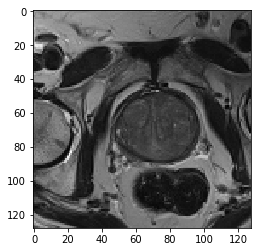

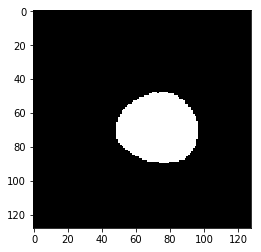

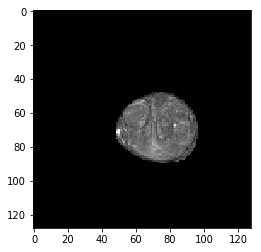

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


# load a training image-label pair
idx = 49
image = np.load(os.path.join(path_to_data, "image_train%02d.npy" % idx))
label = np.load(os.path.join(path_to_data, "label_train%02d.npy" % idx))
size_data = list(image.shape)

# plot the pair
idx_slice = 16
plt.figure()
plt.imshow(image[idx_slice,:,:], cmap='gray')
plt.figure()
plt.imshow(label[idx_slice,:,:], cmap='gray')

# and check to see if the mask is actually segmenting the ROI
plt.figure()
plt.imshow(image[idx_slice,:,:] * label[idx_slice,:,:], cmap='gray')

### Data feeding
For convinience, a very simple class for data feeding is loaded:

In [3]:
# a simple npy image reading class
class DataReader:

    def __init__(self, folder_name):
        self.folder_name = folder_name

    def load_images_train(self, indices_mb):
        return self.load_npy_files(["image_train%02d.npy" % idx for idx in indices_mb])

    def load_images_test(self, indices_mb):
        return self.load_npy_files(["image_test%02d.npy" % idx for idx in indices_mb])

    def load_labels_train(self, indices_mb):
        return self.load_npy_files(["label_train%02d.npy" % idx for idx in indices_mb])

    def load_npy_files(self, file_names):
        images = [np.float32(np.load(os.path.join(self.folder_name, fn))) for fn in file_names]
        return np.expand_dims(np.stack(images, axis=0), axis=4)

## 4.2 Computation Graph for a Fully Convolutional Neural Network
The following script is not optimised for performace or best coding practice. This illustrates a basic working workflow to do image segmentation.

### 4.2.1 Placeholders
This is a special feature in TensorFlow to facilitate runtime data feeding. This will become clear later.

In [4]:
import tensorflow as tf


# --- First define placeholders with fixed sizes
size_minibatch = 4  # number of images as one input minibatch
# only the gray-scale intensity values as one-channel feature, hence [1]:
ph_image = tf.placeholder(tf.float32, [size_minibatch]+size_data+[1])
ph_label = tf.placeholder(tf.float32, [size_minibatch]+size_data+[1])

### 4.2.2 Encoder-decoder network
This is a simplified imlementatin of an encoder-decoder network for image segmentation, similar to [U-Net][unet_paper].

[unet_paper]: https://arxiv.org/abs/1505.04597

In [5]:
# --- usually, there is a data pre-processing (augmentation) layer
# halve image size so this can be reasonably tested, e.g. on a CPU
input_image = ph_image[:, ::2, ::2, ::2, :]
input_label = ph_label[:, ::2, ::2, ::2, :]

# --- add the first block of layers (N.B. "layer" is not used consistently)
k_conv = [3, 3, 3]  # convolution kernel size
nc1 = 8  # number of feature maps after the convolution layer, i.e. channels
# -Step 1- declare variables for storing convolution kernel "weights" to optimise
W1 = tf.get_variable("W1", shape=k_conv+[1, nc1], initializer=tf.contrib.layers.xavier_initializer())
# -Step 2- layers include:
# (a) 3d convolution with padded feature maps (for convenience in working out the sizes at different resolution levels)
# (b) batch normalisation, and
# (c) nonlinear activation (relu in this case)
strides_one = [1, 1, 1, 1, 1]  # stride of the sliding window used in convolution
layer1c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(input_image, W1, strides_one, padding="SAME")))
# -Step 3- polling layer
k_pool = [1, 2, 2, 2, 1]  # kernel for pooling
layer1 = tf.nn.max_pool3d(layer1c, k_pool, strides_one, "SAME")

# --- add down-sampling convolution layers
nc2 = nc1*2  # double the number of feature maps
W2 = tf.get_variable("W2", shape=k_conv+[nc1, nc2], initializer=tf.contrib.layers.xavier_initializer())
layer2c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer1, W2, strides_one, "SAME")))
# down-sample via pooling layer
strides_two = [1, 2, 2, 2, 1]  # stride used for down-sampling and up-sampling
layer2 = tf.nn.max_pool3d(layer2c, k_pool, strides_two, "SAME")

# --- add two more of these down-sampling blocks
nc3 = nc2*2
W3 = tf.get_variable("W3", shape=k_conv+[nc2, nc3], initializer=tf.contrib.layers.xavier_initializer())
layer3c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer2, W3, strides_one, "SAME")))
layer3 = tf.nn.max_pool3d(layer3c, k_pool, strides_two, "SAME")

nc4 = nc3*2
W4 = tf.get_variable("W4", shape=k_conv+[nc3, nc4], initializer=tf.contrib.layers.xavier_initializer())
layer4c = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer3, W4, strides_one, "SAME")))
layer4 = tf.nn.max_pool3d(layer4c, k_pool, strides_two, "SAME")

# --- add a convolution layer without sampling/pooling at the end of down-sampling blocks (i.e. the "encoder")
nc5 = nc4*2
W5 = tf.get_variable("W5", shape=k_conv+[nc4, nc5], initializer=tf.contrib.layers.xavier_initializer())
layer5 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer4, W5, strides_one, "SAME")))


# --- add an up-sampling block (starting the "decoder")
# (a) the number of feature maps are halved;
# (b) use transpose convolution for up-sampling;
# (c) make sure the output size is the same as that of layer4c so they can be added (or concatenated)
W4d = tf.get_variable("W4d", shape=k_conv+[nc4, nc5], initializer=tf.contrib.layers.xavier_initializer())
layer4d = tf.nn.conv3d_transpose(layer5, W4d, output_shape=layer4c.get_shape(), strides=strides_two, padding="SAME")
# (d) add a skip layer (shortcut connection) to the encoder using summation
# (e) then add another convolution, batch normalisation and nonlinear activation
W4dc = tf.get_variable("W4dc", shape=k_conv+[nc4, nc4], initializer=tf.contrib.layers.xavier_initializer())
layer4dc = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer4d+layer4c, W4dc, strides_one, "SAME")))

# --- add another three of these up-sampling blocks, till the original input size
W3d = tf.get_variable("W3d", shape=k_conv+[nc3, nc4], initializer=tf.contrib.layers.xavier_initializer())
layer3d = tf.nn.conv3d_transpose(layer4dc, W3d, layer3c.get_shape(), strides_two, "SAME")
W3dc = tf.get_variable("W3dc", shape=k_conv+[nc3, nc3], initializer=tf.contrib.layers.xavier_initializer())
layer3dc = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer3d+layer3c, W3dc, strides_one, "SAME")))

W2d = tf.get_variable("W2d", shape=k_conv+[nc2, nc3], initializer=tf.contrib.layers.xavier_initializer())
layer2d = tf.nn.conv3d_transpose(layer3dc, W2d, layer2c.get_shape(), strides_two, "SAME")
W2dc = tf.get_variable("W2dc", shape=k_conv+[nc2, nc2], initializer=tf.contrib.layers.xavier_initializer())
layer2dc = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer2d+layer2c, W2dc, strides_one, "SAME")))


# --- add the "read-out" layer with a sigmoid activation
# use single channel for soft Dice loss
W1d = tf.get_variable("W_out", shape=k_conv+[nc2, 1], initializer=tf.contrib.layers.xavier_initializer())
layer1d = tf.sigmoid(tf.contrib.layers.batch_norm(tf.nn.conv3d(layer2dc, W1d, strides_one, "SAME")))

# check if output size is expected: print(layer1d)

### 4.2.3 Loss for image segmentation
Cross-entropy can be used to treat segmentation as a voxel classification problem. Probabilitic (soft) Dice is also widely used.

In [6]:
# loss based on Dice, between predicted segmentation layer_out and ground-truth label
dice_numerator = tf.reduce_sum(layer1d*input_label, axis=[1, 2, 3, 4]) * 2
# adding a small value for numerical stability
dice_denominator = tf.reduce_sum(input_label, axis=[1, 2, 3, 4]) + tf.reduce_sum(layer1d, axis=[1, 2, 3, 4])+1e-6
dice = dice_numerator / dice_denominator
loss = 1 - tf.reduce_mean(dice)

### 4.2.4 Set up the session

In [7]:
# training op
train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
total_iter = int(1e5)
n = 50  # 50 training image-label pairs
num_minibatch = int(n/size_minibatch)  # how many minibatches in each epoch
indices_train = [i for i in range(n)]
# data reader
DataFeeder = DataReader(path_to_data)

### 4.2.5 Minibatch Optimisation
- shuffle data every epoch
- feed one minibatch of the data in each iteration
- print training information
- test during training

In [8]:
import random

# start the optimisation
for step in range(total_iter):

    # shuffle data every time start a new set of minibatches
    if step in range(0, total_iter, num_minibatch):
        random.shuffle(indices_train)

    # arrange data indices for a minibatch
    minibatch_idx = step % num_minibatch  # minibatch index
    indices_mb = indices_train[minibatch_idx*size_minibatch:(minibatch_idx+1)*size_minibatch]
    trainFeed = {ph_image: DataFeeder.load_images_train(indices_mb),
                 ph_label: DataFeeder.load_labels_train(indices_mb)}

    # update the variables
    sess.run(train_op, feed_dict=trainFeed)

    # print training information
    if (step % 10) == 0:
        loss_train = sess.run(loss, feed_dict=trainFeed)
        print('Step %d: Loss=%f' % (step, loss_train))
    if (step % 100) == 0:
        dice_train = sess.run(dice, feed_dict=trainFeed)
        print('Individual training-Dice:')
        print(dice_train)

    # --- simple tests during training ---
    if (step % 500) == 0:
        indices_test = [random.randrange(30) for i in range(size_minibatch)]  # select size_minibatch test data
        testFeed = {ph_image: DataFeeder.load_images_test(indices_test)}
        layer1d_test = sess.run(layer1d, feed_dict=testFeed)
        # save the segmentation
        for idx in range(size_minibatch):
            np.save("./label_test%02d_step%06d.npy" % (indices_test[idx], step), layer1d_test[idx, ...])
        print('Test results saved.')

sess.close()

Step 0: Loss=0.955068
Individual training-Dice:
[ 0.03416616  0.02745877  0.05617623  0.06192501]
Test results saved.


KeyboardInterrupt: 

### Inspect the saved segmentation on test data
- A seperate notebook/terminal might be useful to run the following file-reading, avoiding to kill the optimisation

In [9]:
# available results
!ls

01-CurveFitting.ipynb		       data			    promise12
02-CrossValidation.ipynb	       label_test07_step000000.npy  README.md
03-CurveFitting-TensorFlow.ipynb       label_test09_step000000.npy  test4.py
04-ImageSegmentation-TensorFlow.ipynb  label_test19_step000000.npy


In this case, more than 500 iterations should produce resaonble results on test data, while several thousand should approach convergence. Since the labels for the test data are not available, the results are assessed qualitatively. Alternatively, one should consider using cross-validation on the training data.

As the time of preparing this tutorial, the Challenge still accepts [submissions](https://promise12.grand-challenge.org/evaluation/submissions/create/), although they should be based on original data before resampling.  

(16, 64, 64)


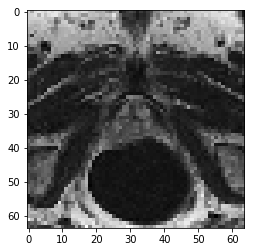

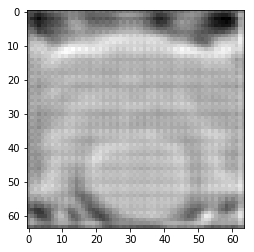

In [12]:
# specify these to plot the results w.r.t. the images
step = 0  
idx_case = 19
idx_slice = 6

image = np.load(os.path.join(path_to_data, "image_test%02d.npy" % idx_case))[::2, ::2, ::2]
label = np.load("label_test%02d_step%06d.npy" % (idx_case, step))[..., 0]
print(label.shape)
plt.figure()
plt.imshow(image[idx_slice,:,:], cmap='gray')
plt.figure()
plt.imshow(label[idx_slice,:,:], cmap='gray')

- If running on Colab, download the saved data:

```python
from google.colab import files

files.download("label_test%02d_step%06d.npy" % (idx_case, step))
```